# Decision Tree Regressor

## Preliminary Setup :

- Open anaconda navigator
- Make sure you have Python 3 or greater environment active
- Install pip into your environment
- Play Button > "Open Terminal"
- pip install ta numpy scipy sklearn matplotlib

## Imports

In [1]:
from ta import *
import pandas, numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

In [4]:
## Read Data
def readDEX(filepath):
    rawData = pandas.read_csv(filepath).replace('.', np.nan).fillna(method='ffill')
    # TODO : Parse dates
    pandas.to_datetime(rawData['DATE'], format='%Y-%m-%d')
    rawData.VALUE = rawData.VALUE.astype(float)
    return rawData

In [5]:
usCa = readDEX('data/DEXCAUS.csv')

### Output Column

In [6]:
others.daily_return(usCa['VALUE'])[:10]

0         NaN
1   -0.069245
2    0.039596
3    0.415595
4    0.059125
5    0.049242
6   -0.285461
7   -0.078973
8    0.108674
9    0.019737
Name: d_ret, dtype: float64

# Building Strategies

In [7]:
usCa['dpo'] = trend.dpo(usCa['VALUE'])
usCa['macd'] = trend.macd(usCa['VALUE'])
usCa['macd_signal'] = trend.macd_signal(usCa['VALUE'])
usCa['macd_diff'] = trend.macd_diff(usCa['VALUE'])
usCa['tsi'] = momentum.tsi(usCa['VALUE'])
usCa['rsi'] = momentum.rsi(usCa['VALUE'])
usCa['trix'] = trend.trix(usCa['VALUE'])
usCa['hband'] = volatility.bollinger_hband(usCa['VALUE'])
usCa['lband'] = volatility.bollinger_lband(usCa['VALUE'])

# Output column
usCa['return'] = others.daily_return(usCa['VALUE'])
usCa['gained'] = usCa['return'] > 0
usCa[:10]

,DATE,VALUE,dpo,macd,macd_signal,macd_diff,tsi,rsi,trix,hband,lband,return,gained
0,1971-01-04,1.0109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1971-01-05,1.0102,NaN,NaN,NaN,NaN,-100.000000,NaN,NaN,NaN,NaN,-0.069245,False
2,1971-01-06,1.0106,NaN,NaN,NaN,NaN,-65.929566,NaN,NaN,NaN,NaN,0.039596,True
3,1971-01-07,1.0148,NaN,NaN,NaN,NaN,21.592445,NaN,NaN,NaN,NaN,0.415595,True
4,1971-01-08,1.0154,NaN,NaN,NaN,NaN,41.553943,NaN,NaN,NaN,NaN,0.059125,True
5,1971-01-11,1.0159,NaN,NaN,NaN,NaN,50.969532,NaN,NaN,NaN,NaN,0.049242,True
6,1971-01-12,1.0130,NaN,NaN,NaN,NaN,43.100626,NaN,NaN,NaN,NaN,-0.285461,False
7,1971-01-13,1.0122,NaN,NaN,NaN,NaN,36.308132,NaN,NaN,NaN,NaN,-0.078973,False
8,1971-01-14,1.0133,NaN,NaN,NaN,NaN,33.336623,NaN,NaN,NaN,NaN,0.108674,True
9,1971-01-15,1.0135,NaN,NaN,NaN,NaN,31.539850,NaN,NaN,NaN,NaN,0.019737,True


In [8]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [9]:
inputCols = ['VALUE', 'dpo', 'macd', 'macd_signal', 'macd_diff', 'tsi', 'rsi', 'trix', 'hband', 'lband']
outputCols = ['return']

## Slice at 25 because that's the last index of a NaN value
## Shift outputs by 1 day forward
offset = 25
inputs = usCa[inputCols][offset:-1]
outputs = usCa[outputCols][offset+1:]

In [10]:
clf = DecisionTreeRegressor(random_state=0)
cross_val_score(clf, inputs, outputs, cv=10)

array([-10.84579612,  -3.03865406,  -2.19333913,  -1.84816799,
        -1.5441984 ,  -1.75119023,  -4.31991314,  -0.7252527 ,
        -1.22998258,  -1.07868335])

In [11]:
clf.fit(inputs, outputs)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [12]:
# Feature importances
srt = sorted(list(zip(inputCols, clf.feature_importances_)), key=lambda x: x[1])
srt.reverse()
srt

[('dpo', 0.1749766178874021),
 ('macd_diff', 0.12667752368642093),
 ('rsi', 0.11984081958107358),
 ('tsi', 0.11015869022268132),
 ('trix', 0.10555126314724007),
 ('macd', 0.09309440803367552),
 ('macd_signal', 0.08299413503953483),
 ('hband', 0.07000429894812481),
 ('lband', 0.06513205099744934),
 ('VALUE', 0.05157019245639747)]

## Make Trades

In [13]:
predictions = clf.predict(inputs)

In [14]:
pd.Series(predictions).describe()

count    12409.000000
mean         0.002902
std          0.402447
min         -4.945140
25%         -0.165180
50%          0.000000
75%          0.164730
max          3.880356
dtype: float64

In [15]:
# Place trades on top 75% and sell when falls below 50%
buyThreshold = 0.164730
sellThreshold = 0.00
buys = predictions > buyThreshold
sells = predictions < sellThreshold

In [16]:
buys

array([False, False, False, ..., False,  True,  True])

In [17]:
buyInds = [i for i, x in enumerate(buys) if x == True]
sellInds = [i for i, x in enumerate(sells) if x == True]

In [18]:
# For each buy position find the next sell position
nextSellInd = []
tmp = np.array(sellInds)
for ind in buyInds:
    vals = np.where(tmp > ind)[0]
    if len(vals):
        indOfNextSell = tmp[vals[0]]
        nextSellInd.append(indOfNextSell)

In [19]:
positions = list(zip(buyInds, nextSellInd))
positions[:10]

[(11, 12),
 (80, 83),
 (82, 83),
 (85, 89),
 (87, 89),
 (94, 96),
 (119, 122),
 (120, 122),
 (128, 129),
 (130, 132)]

In [20]:
pd.Series(list(map(lambda a : a[1] - a[0], positions))).describe()

count    3101.000000
mean        2.091583
std         1.458677
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        11.000000
dtype: float64

In [21]:
enters = [a[0]+offset for a in positions]
exits = [a[1]+offset for a in positions]

In [22]:
# Positions of buys
usCa.loc[enters][:10]

,DATE,VALUE,dpo,macd,macd_signal,macd_diff,tsi,rsi,trix,hband,lband,return,gained
36,1971-02-23,1.0035,0.000420,-0.001741,-0.001518,-0.000223,-14.261394,13.388719,-0.015595,1.010938,1.004822,-0.079657,False
105,1971-05-31,1.0101,0.000120,0.000449,0.000368,0.000081,5.958453,69.951436,0.005377,1.010426,1.007134,0.000000,False
107,1971-06-02,1.0134,-0.000360,0.000922,0.000529,0.000393,9.836610,87.879670,0.007388,1.012242,1.006278,0.079005,True
110,1971-06-07,1.0161,-0.001525,0.002009,0.001163,0.000846,18.614899,71.615636,0.015684,1.017016,1.004434,-0.127777,False
112,1971-06-09,1.0186,-0.002615,0.002466,0.001597,0.000869,22.820015,78.542442,0.021778,1.019263,1.004167,0.068769,True
119,1971-06-18,1.0225,0.001620,0.003941,0.003384,0.000558,36.727359,64.368499,0.048019,1.029204,1.004556,-0.165983,False
144,1971-07-23,1.0151,0.001045,-0.000411,0.000688,-0.001099,21.746195,7.570305,0.010344,1.026294,1.017616,-0.235872,False
145,1971-07-26,1.0176,0.001270,-0.000603,0.000430,-0.001032,19.543567,33.183783,0.006666,1.026484,1.016976,0.246281,True
153,1971-08-05,1.0168,-0.000330,-0.000703,-0.000331,-0.000372,10.241826,33.692712,-0.006067,1.025163,1.015497,-0.166912,False
155,1971-08-09,1.0063,-0.004170,-0.001679,-0.000660,-0.001019,4.443544,18.834869,-0.010482,1.026858,1.011682,-1.207540,False


In [23]:
# Positions of sells
usCa.loc[exits][:10]

,DATE,VALUE,dpo,macd,macd_signal,macd_diff,tsi,rsi,trix,hband,lband,return,gained
37,1971-02-24,1.0075,0.000550,-0.001572,-0.001529,-0.000044,-13.994300,52.751027,-0.016201,1.010627,1.004873,0.398605,True
108,1971-06-03,1.0185,-0.000315,0.001506,0.000724,0.000781,14.023445,94.449092,0.009856,1.014799,1.004831,0.503256,True
108,1971-06-03,1.0185,-0.000315,0.001506,0.000724,0.000781,14.023445,94.449092,0.009856,1.014799,1.004831,0.503256,True
114,1971-06-11,1.0239,-0.003915,0.003439,0.002195,0.001244,29.323051,87.076425,0.030093,1.023543,1.002887,0.000000,False
114,1971-06-11,1.0239,-0.003915,0.003439,0.002195,0.001244,29.323051,87.076425,0.030093,1.023543,1.002887,0.000000,False
121,1971-06-22,1.0243,-0.002300,0.003854,0.003562,0.000292,37.840999,70.943293,0.051358,1.030199,1.006601,0.009764,True
147,1971-07-28,1.0221,0.001565,-0.000312,0.000130,-0.000442,17.980281,58.422422,0.001840,1.026203,1.016867,0.156786,True
147,1971-07-28,1.0221,0.001565,-0.000312,0.000130,-0.000442,17.980281,58.422422,0.001840,1.026203,1.016867,0.156786,True
154,1971-08-06,1.0186,-0.002610,-0.000704,-0.000406,-0.000299,9.278005,45.678142,-0.007209,1.024830,1.015390,0.177026,True
157,1971-08-11,1.0143,0.002180,-0.001940,-0.001116,-0.000825,0.988931,44.168184,-0.016636,1.026180,1.010460,0.148104,True


In [24]:
gains = list(map(lambda pos : usCa['VALUE'][pos[1]+offset]-usCa['VALUE'][pos[0]+offset], positions))
gains[:10]

[0.0040000000000000036,
 0.008399999999999963,
 0.005099999999999882,
 0.007800000000000029,
 0.005300000000000082,
 0.0018000000000000238,
 0.007000000000000117,
 0.0044999999999999485,
 0.0018000000000000238,
 0.008000000000000007]

In [25]:
pos = positions[1]
np.divide(np.sum(usCa['return'].shift(1)[pos[0]:pos[1]]), 100)

0.0018845769011603952

In [26]:
trade_returns = list(map(lambda pos : np.add(np.divide(np.sum(usCa['return'].shift(1)[pos[0]:pos[1]]), 100), 1.0), positions))

In [27]:
trade_returns

[0.999111988159842,
 1.0018845769011604,
 1.000297265160523,
 0.9988109296591597,
 0.9985133894071211,
 1.0005950609937517,
 0.9998075233871462,
 1.0000027596229915,
 1.000488758553275,
 0.9994136043784205,
 0.9998045348077528,
 0.9997067830970979,
 0.9976531087947812,
 1.0024628115456606,
 1.002577329998005,
 0.9944590699777427,
 0.9947554540915542,
 0.9989050667116355,
 0.9992036335906164,
 0.9999004977021145,
 1.000099740674247,
 0.9991030495599688,
 0.9997008973080758,
 0.99789536981359,
 1.000198856575187,
 1.0001008064516128,
 0.9990924789692994,
 1.0005051933991682,
 1.0002020406101626,
 0.99554512383427,
 0.9961522883758607,
 0.9977528089887641,
 1.0007126029110254,
 1.0007126029110254,
 1.001017904967972,
 1.000712468193384,
 1.000101440452366,
 1.0002028603306623,
 1.001012555690563,
 1.0016100734429942,
 0.9989009993806072,
 0.9977005191885305,
 1.0006003602161297,
 1.0004032664583122,
 0.9994973358801649,
 0.999401078059493,
 0.9971293006428871,
 0.9998020006438375,
 0.9988

In [28]:
pd.Series(trade_returns).describe()

count    3101.000000
mean        1.000170
std         0.006950
min         0.950379
25%         0.997429
50%         1.000000
75%         1.002804
max         1.090912
dtype: float64

In [31]:
np.percentile(trade_returns, 75)

1.002803925495694

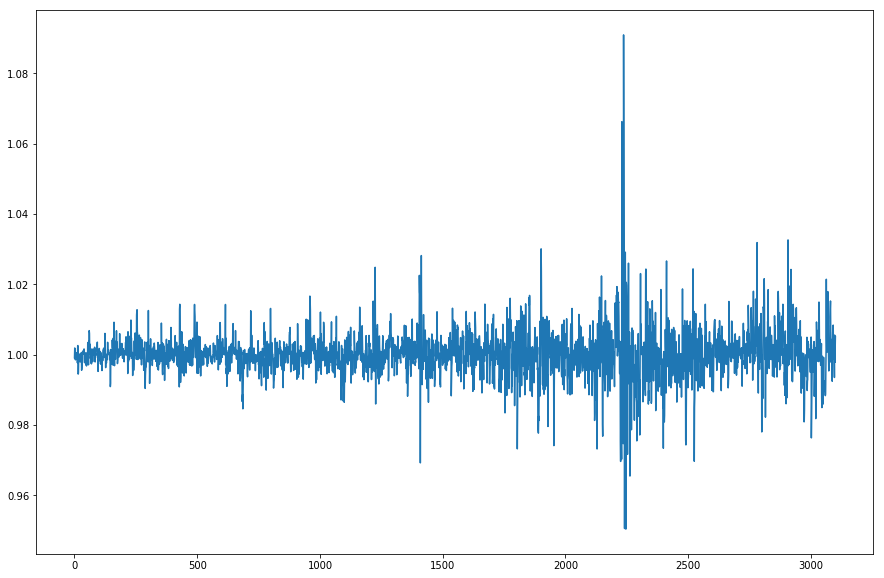

In [32]:
plt.plot(trade_returns)

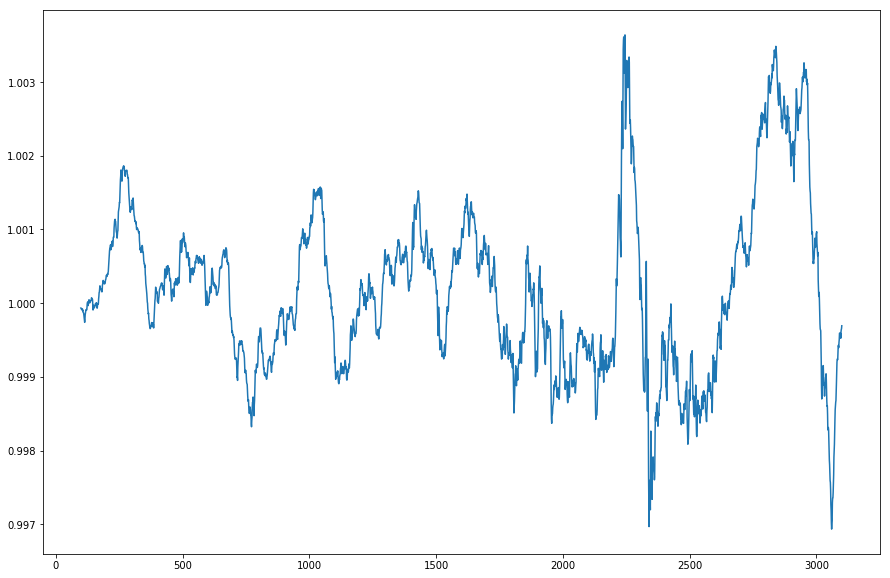

In [33]:
plt.plot(pandas.Series(trade_returns).rolling(100).mean())

In [34]:
print('Sum of percentage gains :', sum(trade_returns))
print('Compounded gains : ', np.prod(trade_returns))

Sum of percentage gains : 3101.5271892319765
Compounded gains :  1.5724502753210805


## Automate

In [36]:
def runDTBacktest(filename):
    df = readDEX(filename)

    input_calculators=[trend.dpo, trend.macd, trend.macd_signal, trend.macd_diff, momentum.tsi, momentum.rsi, trend.trix, volatility.bollinger_hband, volatility.bollinger_lband]
    output_calculators=[lambda s : others.daily_return(s).shift(-1)]
    
    df_inds = runCalculators(df.VALUE, input_calculators)
    df_outs = runCalculators(df.VALUE, output_calculators)
    df = pd.concat([df, df_inds, df_outs], axis=1, join_axes=[df.index])
    df = df.dropna()
    df_inds = df[df_inds.columns]
    df_outs = df[df_outs.columns]
    
    train_split = 0.8
    train_in, test_in = splitData(df_inds, train_split)
    train_out, test_out = splitData(df_outs, train_split)
    
    decTree = trainDecisionTree(train_in, train_out)
    preds = decTree.predict(test_in)
    
    trades = makeTrades(preds)
    totalGain = getCompoundGains(df.VALUE, trades)
    
    return {
        'filename':filename,
        'gain' : totalGain,
        'df':df,
        'trades':trades,
        'test_df':pd.concat([df, test_in, test_out], axis=1, join_axes=[test_in.index])
    }
    

def runCalculators(series, calculators=[]):
    df_obj = {}
    for ind, fn in enumerate(calculators):
        df_obj[fn.__name__] = fn(series)
    return pd.DataFrame(df_obj)


def splitData(df, split):
    train = df.iloc[:int(len(df)*split)]
    test = df.iloc[int(len(df)*split):]
    
    return train, test


def trainDecisionTree(inputDf, outputDf):
    clf = DecisionTreeRegressor(random_state=0)
    clf.fit(inputDf, outputDf)
    return clf


def makeTrades(predictions):
#     ceil = np.percentile(predictions, 75)
#     floor = np.percentile(predictions, 50)
    thresh = np.percentile(predictions, 60)
    
    trade_pos = np.where(predictions > thresh)[0]
    return trade_pos

def getCompoundGains(series, trades):
    gains = others.daily_return(series).shift(-1)[trades]
    gains = np.add(np.divide(gains, 100), 1.0)
    return np.product(gains)

In [37]:
res = runDTBacktest('data/DEXCAUS.csv')

/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [38]:
res['test_df']

,DATE,VALUE,dpo,macd,macd_signal,macd_diff,tsi,rsi,trix,bollinger_hband,...,dpo,macd,macd_signal,macd_diff,tsi,rsi,trix,bollinger_hband,bollinger_lband,<lambda>
9952,2009-02-25,1.2558,-0.008850,0.006316,0.005595,0.000721,6.614147,59.161173,0.064472,1.267328,...,-0.008850,0.006316,0.005595,0.000721,6.614147,59.161173,0.064472,1.267328,1.216772,-0.820194
9953,2009-02-26,1.2455,-0.001590,0.005565,0.005589,-0.000024,6.502831,47.663243,0.065065,1.266174,...,-0.001590,0.005565,0.005589,-0.000024,6.502831,47.663243,0.065065,1.266174,1.220606,2.047371
9954,2009-02-27,1.2710,0.002685,0.006947,0.005860,0.001086,6.999549,66.346815,0.068252,1.270749,...,0.002685,0.006947,0.005860,0.001086,6.999549,66.346815,0.068252,1.270749,1.219481,1.424076
9955,2009-03-02,1.2891,-0.004030,0.009394,0.006567,0.002827,7.870266,73.960190,0.075758,1.279716,...,-0.004030,0.009394,0.006567,0.002827,7.870266,73.960190,0.075758,1.279716,1.215344,0.356838
9956,2009-03-03,1.2937,-0.007045,0.011572,0.007568,0.004004,8.760699,75.580209,0.086395,1.288020,...,-0.007045,0.011572,0.007568,0.004004,8.760699,75.580209,0.086395,1.288020,1.213070,-1.306331
9957,2009-03-04,1.2768,0.007555,0.011798,0.008414,0.003384,9.095789,59.807257,0.095821,1.290521,...,0.007555,0.011798,0.008414,0.003384,9.095789,59.807257,0.095821,1.290521,1.215569,0.838033
9958,2009-03-05,1.2875,0.003315,0.012694,0.009270,0.003424,9.643248,65.124328,0.105518,1.294812,...,0.003315,0.012694,0.009270,0.003424,9.643248,65.124328,0.105518,1.294812,1.216958,-0.077670
9959,2009-03-06,1.2865,0.000730,0.013172,0.010051,0.003121,10.107405,64.208359,0.114601,1.298609,...,0.000730,0.013172,0.010051,0.003121,10.107405,64.208359,0.114601,1.298609,1.217931,1.010494
9960,2009-03-09,1.2995,-0.007995,0.014433,0.010927,0.003506,10.824114,70.443918,0.124688,1.302198,...,-0.007995,0.014433,0.010927,0.003506,10.824114,70.443918,0.124688,1.302198,1.222392,-1.531358
9961,2009-03-10,1.2796,-0.013815,0.013669,0.011476,0.002194,10.902110,53.867864,0.131625,1.302752,...,-0.013815,0.013669,0.011476,0.002194,10.902110,53.867864,0.131625,1.302752,1.226478,0.093779


In [39]:
np.product(np.add(np.divide(others.daily_return(readDEX('data/DEXCAUS.csv').VALUE), 100), 1))

1.293105153823329

In [40]:
np.product(np.add(np.divide(others.daily_return(res['test_df'].VALUE), 100), 1))

1.0344800127408886

In [41]:
from os import listdir
# onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
data_dir = 'data/'
data_files = list(filter(lambda a : ('.csv' in a), listdir('data/')))
results = [runDTBacktest(data_dir + f) for f in data_files]
# gains_by_pair = sorted(list(zip(data_files, compound_gains)), key=lambda x: x['gain'])
# gains_by_pair.reverse()

/anaconda2/envs/py36/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [55]:
# metrics
def getMetrics(backTestResult):
    
    returns = np.add(np.divide(others.daily_return(backTestResult['test_df'].VALUE),100),1)
    
    return {
        'filename' : backTestResult['filename'],
        'gain' : backTestResult['gain'],
        'total_gain' : np.product(returns),
        'beat_market' : backTestResult['gain'] > np.product(returns),
        'start_date' : backTestResult['test_df']['DATE'].iloc[0],
        'end_date' : backTestResult['test_df']['DATE'].iloc[-1]
#         'perfect_gain' : np.product(returns[np.where(returns > 1.0)])
    }


sortedResults = sorted(list(map(getMetrics, results)), key=lambda x: x['gain'])
sortedResults.reverse()
sortedResults

[{'filename': 'data/DEXBZUS.csv',
  'gain': 2.1895673761995407,
  'total_gain': 1.7978605049208363,
  'beat_market': True,
  'start_date': '2013-12-13',
  'end_date': '2018-08-30'},
 {'filename': 'data/DEXMXUS.csv',
  'gain': 1.3292298093707893,
  'total_gain': 1.4993738749315093,
  'beat_market': False,
  'start_date': '2013-09-20',
  'end_date': '2018-08-30'},
 {'filename': 'data/DEXHKUS.csv',
  'gain': 1.2072556849641107,
  'total_gain': 1.0071086702680478,
  'beat_market': True,
  'start_date': '2011-02-25',
  'end_date': '2018-08-30'},
 {'filename': 'data/DEXCHUS.csv',
  'gain': 1.2016338061646914,
  'total_gain': 1.0405481452189416,
  'beat_market': True,
  'start_date': '2011-02-25',
  'end_date': '2018-08-30'},
 {'filename': 'data/DEXVZUS.csv',
  'gain': 1.1920633384310044,
  'total_gain': 9.70166449202593,
  'beat_market': False,
  'start_date': '2013-12-17',
  'end_date': '2018-08-30'},
 {'filename': 'data/DEXMAUS.csv',
  'gain': 1.123355983524961,
  'total_gain': 1.120261794

In [60]:
np.sum(list(map(lambda a : a['beat_market'], sortedResults)))/float(len(sortedResults))

0.3076923076923077